In [1]:
import torch
from transformers import (
    AutoModel,
    AutoTokenizer,
)
from datasets import load_dataset
import pandas as pd
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
import umap

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def cls_pooling(model_output):
    return model_output[0][:, 0]

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, torch_dtype=torch.float16)
device='mps'
model = model.to(device)

def get_embedding(text, use_mean_pooling=True):
   
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=512
    )
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    with torch.no_grad():
        model_output = model(**inputs)
    if use_mean_pooling:
        return mean_pooling(model_output, inputs["attention_mask"])
    return cls_pooling(model_output)


def get_similarity(text1, text2, pooling_method, model_id):
    use_mean_pooling = pooling_method == "mean"
    embedding1 = get_embedding(text1, use_mean_pooling, model_id)
    embedding2 = get_embedding(text2, use_mean_pooling, model_id)
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).item()

## Let's load human and AI written texts first

In [3]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
del dolly
sample.head(2)

,index,instruction,num_tokens,num_tokens_round,num_words_round,response,prompt_id
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,211,210,180,"Dear Mum, I would like to talk to you about the monthly money I get for my studies. I am very grateful that you support me financially during my studies. At the same time, I feel that the current amount is a little bit too low in order to sustain myself. I estimated my monthly expenses and it seems like the money is not enough. We can go through the details if you want. I want to ask you if you can increase the amount so that I can cover my expenses. I understand if you cannot do this or have other reasons against this. However, I want you to know that if you do not increase my monthly money, I will be forced to work part-time next to my studies. There is research that shows that students who work part-time have worse grades than people who do not have to work part-time to afford their studies. I would love to dedicate my full time to my studies to get the best grades and learning outcomes possible; thus, I would prefer not to work part-time. What do you think?",0
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth",189,190,160,"There are several strong arguments against concluding that alien races built the structures like the Stonehenge or the Pyramids. First, there is evidence that these magnificent structures were built by humans. For example, tombs of the pyramid builders were found in the vicinity of the Great Pyramind (with human remains!). The technology to move and assemble the massive stones of the Stonehenge has been shown to be available to humans at that time. Second, given that space is vast the chance of finding one tiny planet among billions is infinitesimal. If alien intelligence had indeed found our one inhabited planet they are unlikely to have just created couple of structures and avoided any further contact with Earth and its inhabitants. In science, Occam’s Razor (“the best explanation is the simplest one”) is a guiding principle and until there is much more evidence of alien visitation it would be inadvisable to jump to a conclusion that aliens built these structures.",1


In [4]:
sample.shape

(100, 7)

In [6]:
dolly_responses = sample.response.values.tolist()
dolly_embeds_mean = []
dolly_embeds_cls = []
for resp in tqdm(dolly_responses):
    dolly_embeds_mean.append(get_embedding(resp, use_mean_pooling=True).detach().cpu().numpy().squeeze())
    dolly_embeds_cls.append(get_embedding(resp, use_mean_pooling=False).detach().cpu().numpy().squeeze())

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.73it/s]


## Check distances with no persona first

In [8]:
np_df = pd.read_csv('../output/llama8b-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
np_df['response'] = np_df.response.apply(lambda x: x.strip())
np_df['prompt_id'] = [i for i in range(len(sample))]
np_embeds_mean = []
np_embeds_cls = []
for resp in tqdm(np_df.response):
    np_embeds_mean.append(get_embedding(resp, use_mean_pooling=True).detach().cpu().numpy().squeeze())
    np_embeds_cls.append(get_embedding(resp, use_mean_pooling=False).detach().cpu().numpy().squeeze())

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.84it/s]


In [10]:
npc_df = pd.read_csv('../output/llama8b-cutoff-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
npc_df['response'] = npc_df.response.apply(lambda x: x.strip())
npc_df['prompt_id'] = [i for i in range(len(sample))]
npc_embeds_mean = []
npc_embeds_cls = []
for resp in tqdm(npc_df.response):
    npc_embeds_mean.append(get_embedding(resp, use_mean_pooling=True).detach().cpu().numpy().squeeze())
    npc_embeds_cls.append(get_embedding(resp, use_mean_pooling=False).detach().cpu().numpy().squeeze())

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


In [13]:
all_embeds = dolly_embeds_mean + np_embeds_mean + npc_embeds_mean
labels = ['human']*100 + ['np']*100 + ['np+cutoff']*100
color = [0]*100 + [1]*100 + [2]*100
all_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(all_embeds)

/Users/venkat/micromamba/envs/nlp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


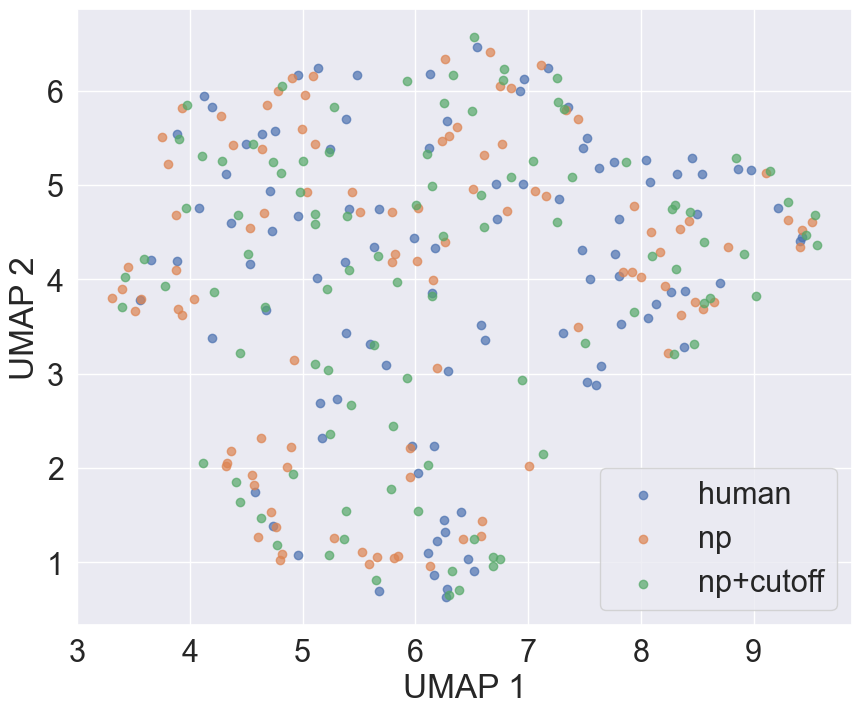

In [14]:
# Create scatter plot
plt.figure(figsize=(10, 8))
for label in ['human', 'np', 'np+cutoff']:
    mask = np.array(labels) == label
    plt.scatter(all_umap[mask, 0], all_umap[mask, 1], 
                label=label, alpha=0.7)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

## Nearest neighbor distance

In [15]:
from sklearn.neighbors import NearestNeighbors

def average_nn_distance(embeddings, n_neighbors=5):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(embeddings)  # +1 because it includes the point itself
    distances, _ = nbrs.kneighbors(embeddings)
    # Exclude the first column (distance to self = 0)
    return np.mean(distances[:, 1:]), np.median(distances[:, 1:]), np.std(distances[:, 1:])

In [18]:
dolly_mean, dolly_median, dolly_std = average_nn_distance(dolly_embeds_mean, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for Dolly mean embeddings:\n {np.round(dolly_mean,2)}, {np.round(dolly_median,2)}, {np.round(dolly_std,2)}")

Mean, median, stdev to 10 nearest neighbors for Dolly mean embeddings:
 12.66, 12.56, 1.77


In [19]:
dolly_mean, dolly_median, dolly_std = average_nn_distance(dolly_embeds_cls, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for Dolly cls embeddings:\n {np.round(dolly_mean,2)}, {np.round(dolly_median,2)}, {np.round(dolly_std,2)}")

Mean, median, stdev to 10 nearest neighbors for Dolly cls embeddings:
 18.12, 17.92, 2.31


In [20]:
np_mean, np_median, np_std = average_nn_distance(np_embeds_mean, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for No persona mean embeddings:\n {np.round(np_mean,2)}, {np.round(np_median,2)}, {np.round(np_std,2)}")

Mean, median, stdev to 10 nearest neighbors for Dolly mean embeddings:
 10.82, 10.67, 1.73


In [22]:
np_mean, np_median, np_std = average_nn_distance(np_embeds_cls, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for No persona CLS embeddings:\n {np.round(np_mean,2)}, {np.round(np_median,2)}, {np.round(np_std,2)}")

Mean, median, stdev to 10 nearest neighbors for No persona CLS embeddings:
 17.82, 17.46, 2.51


In [23]:
npc_mean, npc_median, npc_std = average_nn_distance(npc_embeds_mean, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for No persona+cutoff mean embeddings:\n {np.round(npc_mean,2)}, {np.round(npc_median,2)}, {np.round(npc_std,2)}")

Mean, median, stdev to 10 nearest neighbors for No persona+cutoff mean embeddings:
 12.52, 12.17, 2.2


In [24]:
npc_mean, npc_median, npc_std = average_nn_distance(npc_embeds_cls, 10)
print(f"Mean, median, stdev to 10 nearest neighbors for No persona+cutoff CLS embeddings:\n {np.round(npc_mean,2)}, {np.round(npc_median,2)}, {np.round(npc_std,2)}")

Mean, median, stdev to 10 nearest neighbors for No persona+cutoff CLS embeddings:
 18.32, 17.98, 3.04


## Distances per persona for Llama-8b responses

In [28]:
for persona_id in llama8b.persona_id.sample(n=5, random_state=1):
    print(f"PERSONA ID: {persona_id}")
    for keep in ['first', 'last', 'mid']:
        print(f"{keep}")
        if keep=='mid':
            responses = llama8b.loc[llama8b.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
        else:
            responses = llama8b.loc[llama8b.persona_id==persona_id].drop_duplicates(subset=['persona_id', 'prompt_id'], keep=keep)['response'].values.tolist()
        
        embeds = [get_embedding(resp).detach().cpu().numpy().squeeze() for resp in responses]
        embeds_mean, embeds_median, embeds_std = average_nn_distance(embeds, 10)
        print(f"Mean, median, stdev dist to 10 nearest neighbors: {np.round(embeds_mean,2)}, {np.round(embeds_median,2)}, {np.round(embeds_std,2)}")

PERSONA ID: 35
first
Mean, median, stdev dist to 10 nearest neighbors: 8.94, 8.86, 1.18
last
Mean, median, stdev dist to 10 nearest neighbors: 9.31, 9.33, 0.95
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.08, 9.13, 0.99
PERSONA ID: 41
first
Mean, median, stdev dist to 10 nearest neighbors: 9.38, 9.23, 1.33
last
Mean, median, stdev dist to 10 nearest neighbors: 9.31, 8.89, 1.82
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.22, 9.0, 1.64
PERSONA ID: 98
first
Mean, median, stdev dist to 10 nearest neighbors: 8.58, 8.47, 1.23
last
Mean, median, stdev dist to 10 nearest neighbors: 8.54, 8.43, 1.22
mid
Mean, median, stdev dist to 10 nearest neighbors: 8.63, 8.57, 0.92
PERSONA ID: 29
first
Mean, median, stdev dist to 10 nearest neighbors: 9.13, 9.04, 1.4
last
Mean, median, stdev dist to 10 nearest neighbors: 9.19, 9.14, 1.29
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.24, 9.27, 1.54
PERSONA ID: 70
first
Mean, median, stdev dist to 10 nearest neighbors: 9.86, 9

KeyboardInterrupt: 

## LLama-8b no persona responses

In [31]:
llama8b_np = pd.read_csv('../output/Llama-3.1-8B-Instruct_dollynp_output.tsv', sep='\t')

persona_ids = []
prompt_ids = []
for persona_id in [-1]:
    for prompt_id in range(100):
        persona_ids += [persona_id]*3
        prompt_ids += [prompt_id]*3
        
llama8b_np['persona_id'] = persona_ids
llama8b_np['prompt_id'] = prompt_ids

In [33]:
for keep in ['first', 'last', 'mid']:
    if keep=='mid':
        responses = llama8b_np.groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
    else:
        responses = llama8b_np.drop_duplicates(subset=['persona_id', 'prompt_id'], keep=keep)['response'].values.tolist()

    embeds = [get_embedding(resp).detach().cpu().numpy().squeeze() for resp in responses]
    embeds_mean, embeds_median, embeds_std = average_nn_distance(embeds, 10)
    print(f"{keep} Mean, median, stdev to 10 nearest neighbors for resp embeddings: {np.round(embeds_mean,2)}, {np.round(embeds_median,2)}, {np.round(embeds_std,2)}")

first Mean, median, stdev to 10 nearest neighbors for resp embeddings: 11.48, 11.29, 1.55
last Mean, median, stdev to 10 nearest neighbors for resp embeddings: 11.42, 11.18, 1.78
mid Mean, median, stdev to 10 nearest neighbors for resp embeddings: 11.72, 11.57, 1.69


In [18]:
len(prompt_ids)

300

## Llama-90b persona responses

In [36]:
llama90b = pd.read_csv('../output/llama_3.2_90b_dolly_output.csv', sep=',')

persona_ids = []
prompt_ids = []
for persona_id in range(100):
    for prompt_id in range(100):
        persona_ids += [persona_id]*3
        prompt_ids += [prompt_id]*3
        
llama90b['persona_id'] = persona_ids
llama90b['prompt_id'] = prompt_ids

In [37]:
llama90b.shape

(30000, 4)

In [38]:
for persona_id in llama90b.persona_id.sample(n=5, random_state=1):
    print(f"PERSONA ID: {persona_id}")
    for keep in ['first', 'last', 'mid']:
        print(f"{keep}")
        if keep=='mid':
            responses = llama90b.loc[llama90b.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
        else:
            responses = llama90b.loc[llama90b.persona_id==persona_id].drop_duplicates(subset=['persona_id', 'prompt_id'], keep=keep)['response'].values.tolist()
        
        embeds = [get_embedding(resp).detach().cpu().numpy().squeeze() for resp in responses]
        embeds_mean, embeds_median, embeds_std = average_nn_distance(embeds, 10)
        print(f"Mean, median, stdev dist to 10 nearest neighbors: {np.round(embeds_mean,2)}, {np.round(embeds_median,2)}, {np.round(embeds_std,2)}")

PERSONA ID: 35
first
Mean, median, stdev dist to 10 nearest neighbors: 10.3, 10.22, 1.24
last
Mean, median, stdev dist to 10 nearest neighbors: 10.08, 10.09, 1.49
mid
Mean, median, stdev dist to 10 nearest neighbors: 10.49, 10.27, 1.43
PERSONA ID: 41
first
Mean, median, stdev dist to 10 nearest neighbors: 9.89, 9.88, 1.46
last
Mean, median, stdev dist to 10 nearest neighbors: 9.75, 9.69, 1.23
mid
Mean, median, stdev dist to 10 nearest neighbors: 10.09, 10.06, 1.31
PERSONA ID: 98
first
Mean, median, stdev dist to 10 nearest neighbors: 10.01, 9.93, 1.25
last
Mean, median, stdev dist to 10 nearest neighbors: 10.05, 10.03, 1.2
mid
Mean, median, stdev dist to 10 nearest neighbors: 10.06, 9.99, 1.26
PERSONA ID: 29
first
Mean, median, stdev dist to 10 nearest neighbors: 10.15, 10.08, 1.36
last
Mean, median, stdev dist to 10 nearest neighbors: 10.03, 10.07, 1.11
mid
Mean, median, stdev dist to 10 nearest neighbors: 10.14, 10.06, 1.2
PERSONA ID: 70
first
Mean, median, stdev dist to 10 nearest n

## Claude

In [46]:
claude = pd.read_csv('../output/claude_3.5_sonnet_v2_dolly_output.csv', sep=',')
print(claude.shape)
persona_ids = []
prompt_ids = []
for persona_id in range(43):
    for prompt_id in range(100):
        persona_ids += [persona_id]*3
        prompt_ids += [prompt_id]*3

for persona_id in [44]:
    for prompt_id in range(55):
        persona_ids += [persona_id]*3
        prompt_ids += [prompt_id]*3
        
claude['persona_id'] = persona_ids
claude['prompt_id'] = prompt_ids

(13065, 2)


In [47]:
for persona_id in claude.persona_id.sample(n=5, random_state=1):
    print(f"PERSONA ID: {persona_id}")
    for keep in ['first', 'last', 'mid']:
        print(f"{keep}")
        if keep=='mid':
            responses = claude.loc[claude.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
        else:
            responses = claude.loc[claude.persona_id==persona_id].drop_duplicates(subset=['persona_id', 'prompt_id'], keep=keep)['response'].values.tolist()
        
        embeds = [get_embedding(resp).detach().cpu().numpy().squeeze() for resp in responses]
        embeds_mean, embeds_median, embeds_std = average_nn_distance(embeds, 10)
        print(f"Mean, median, stdev dist to 10 nearest neighbors: {np.round(embeds_mean,2)}, {np.round(embeds_median,2)}, {np.round(embeds_std,2)}")

PERSONA ID: 5
first
Mean, median, stdev dist to 10 nearest neighbors: 8.69, 8.55, 1.08
last
Mean, median, stdev dist to 10 nearest neighbors: 8.82, 8.67, 1.18
mid
Mean, median, stdev dist to 10 nearest neighbors: 8.91, 8.89, 1.47
PERSONA ID: 31
first
Mean, median, stdev dist to 10 nearest neighbors: 9.36, 9.34, 1.3
last
Mean, median, stdev dist to 10 nearest neighbors: 9.26, 9.2, 1.16
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.39, 9.31, 1.27
PERSONA ID: 7
first
Mean, median, stdev dist to 10 nearest neighbors: 9.08, 8.98, 1.04
last
Mean, median, stdev dist to 10 nearest neighbors: 9.02, 9.1, 1.33
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.0, 9.04, 1.27
PERSONA ID: 33
first
Mean, median, stdev dist to 10 nearest neighbors: 8.95, 8.88, 1.08
last
Mean, median, stdev dist to 10 nearest neighbors: 9.07, 8.98, 1.15
mid
Mean, median, stdev dist to 10 nearest neighbors: 9.05, 9.05, 0.95
PERSONA ID: 15
first
Mean, median, stdev dist to 10 nearest neighbors: 8.59, 8.45,

In [49]:
claude['response'][0]

'As a PR professional who regularly crafts persuasive messages, I\'ll help you frame this request strategically:\n\nFirst, I recommend approaching this as a professional "pitch" with clear data points and benefits, rather than just asking for more money. Here\'s how I\'d structure your argument:\n\n1. Start with appreciation: Acknowledge your mother\'s current support and express genuine gratitude. This establishes goodwill.\n\n2. Present market research:\n- Compare your current allowance with average student living costs\n- Show specific price increases in student essentials (housing, books, food)\n- Present a detailed monthly budget showing the gap\n\n3. Position it as an investment:\n- Emphasize how adequate financial support allows you to focus on studies rather than seeking part-time work\n- Highlight how better financial stability can lead to improved academic performance\n- Stress that this is a temporary investment in your future career\n\n4. Offer compromise solutions:\n- Prop